In [1]:
import pennylane as qml
import numpy as np
from matplotlib import pyplot as plt
from pennylane import numpy as pnp

import os
import sys
import time

sys.path.append(os.path.abspath('..'))
from src.utils import *

import warnings
warnings.filterwarnings('ignore')

## 3.1 Carregar Dados do Bloco Anterior

In [27]:
X_train = np.load('../data/X_train.npy')
X_test = np.load('../data/X_test.npy')
y_train = np.load('../data/y_train.npy')
y_test = np.load('../data/y_test.npy')

# Converter labels para {-1, +1}
y_train_quantum = convert_labels_to_quantum(y_train)
y_test_quantum = convert_labels_to_quantum(y_test)

Shapes:
   X_train: (80, 2)
   X_test:  (20, 2)

     Feature 1  Feature 2  Label  Quantum
------------------------------------------
  0    -1.5868     0.5012      0       -1
  1     0.2610    -1.3029      1        1
  2     0.0212    -0.7881      1        1
  3    -0.1020    -0.8607      1        1
  4     1.1538    -1.3209      1        1


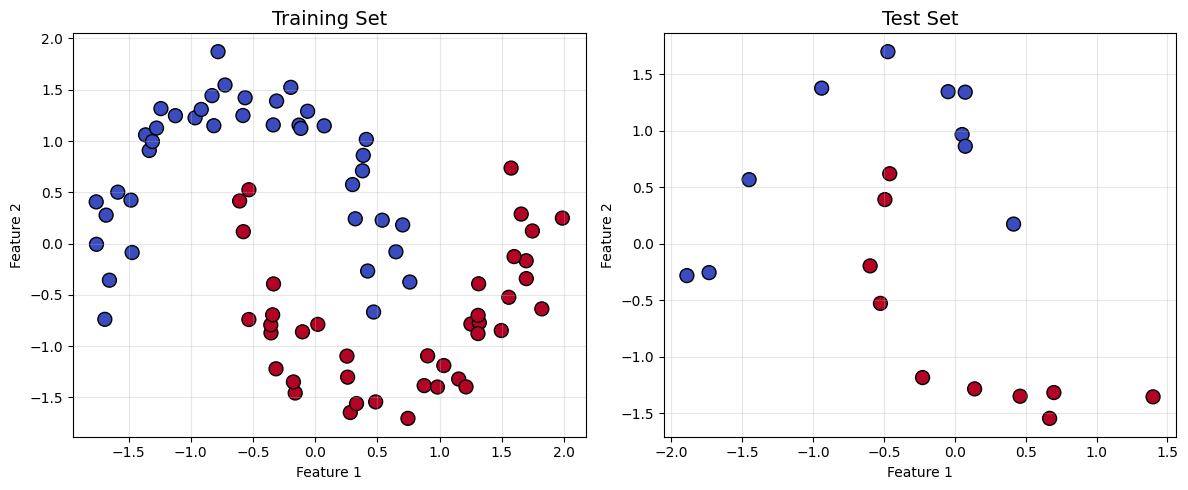

In [28]:
# Shapes
print(f"Shapes:")
print(f"   X_train: {X_train.shape}")
print(f"   X_test:  {X_test.shape}\n")

# Primeiras amostras
print(f"{'':>3} {'Feature 1':>10} {'Feature 2':>10} {'Label':>6} {'Quantum':>8}")
print("-" * 42)
for i in range(min(5, len(X_train))):
    print(f"{i:>3} {X_train[i, 0]:>10.4f} {X_train[i, 1]:>10.4f} {y_train[i]:>6} {y_train_quantum[i]:>8}")

# Visualizar distribuição dos dados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Treino
ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', edgecolors='k', s=100)
ax1.set_title('Training Set', fontsize=14)
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.grid(True, alpha=0.3)

# Teste
ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', edgecolors='k', s=100)
ax2.set_title('Test Set', fontsize=14)
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Por que {-1, +1}?



**Razões para converter labels de {0, 1} para {-1, +1}:**

1. **Alinhamento com expectation values**
   - PauliZ retorna naturalmente valores em [-1, 1]
   - Não precisamos de função de ativação adicional
   
2. **Facilita interpretação**
   - Saída positiva → classe 1
   - Saída negativa → classe 0
   - Magnitude indica confiança
   
3. **Melhor comportamento do gradiente**
   - Labels {-1, +1} são simétricos em torno de zero
   - Gradientes ficam mais balanceados
   
4. **Compatibilidade com funções de loss**
   - MSE funciona melhor com targets simétricos
   - Alternativa: hinge loss, que também usa {-1, +1}

## 3.2 Configuração do Quantum Device

In [4]:
N_QUBITS = 2
N_LAYERS = 2
Q_CIRCUIT_GD = create_variational_circuit(N_QUBITS, n_layers=N_LAYERS, diff_method='parameter-shift')
Q_CIRCUIT_SPSA = create_variational_circuit(N_QUBITS, n_layers=N_LAYERS, diff_method='spsa')

### Como funciona o QNode?

**Pipeline do QNode:**

1. **Input clássico** → Recebe `x` (features) e `params` (pesos treináveis)
2. **Angle Embedding** → Codifica `x` em rotações: cada feature vira um ângulo RY
3. **Variational Layers** → Aplica rotações parametrizadas (Rot gates) + entanglement (CNOT)
4. **Measurement** → Mede PauliZ no primeiro qubit
5. **Output** → Retorna expectation value ∈ [-1, 1]

**Por que PauliZ?**
- PauliZ mede probabilidade de estado |0⟩ vs |1⟩
- Retorna valores em [-1, +1], perfeito para classificação binária
- +1 indica classe positiva, -1 indica classe negativa

**Diferencial do QNode:**
- `diff_method='parameter-shift'` → PennyLane calcula gradientes quanticamente
- Permite treinar circuito como uma rede neural clássica

### Circuito de Layer fortemente entrelaçada
[qml.StronglyEntanglingLayers](https://docs.pennylane.ai/en/stable/code/api/pennylane.StronglyEntanglingLayers.html)

### Por que MSE?



**Vantagens do Mean Squared Error para QML:**

1. **Função diferenciável** → Gradientes bem definidos em todo o domínio
2. **Funciona bem com expectation values** → Saídas contínuas em [-1, 1]
3. **Simples e eficiente** → Menos custo computacional que outras losses
4. **Penaliza erros grandes** → Quadrado amplifica desvios significativos

**Outras opções:**
- **Hinge loss**: Usado em SVMs, também funciona com {-1, +1}
- **Cross-entropy**: Requer conversão para probabilidades [0, 1]
- **Absolute loss**: Menos sensível a outliers, mas gradiente constante

Para este projeto, MSE é ideal porque:
- O dataset é pequeno (sem outliers extremos)
- Queremos treinar rápido (demo)
- Gradientes informativos ajudam convergência

## 3.6 (Demo) Quantum Gradients: Parameter-Shift

Demonstração de como o PennyLane calcula gradientes quânticos.

In [7]:
dummy_params = pnp.random.random((N_LAYERS, N_QUBITS, 3), requires_grad=True)
dummy_x = X_train[0]
dummy_y = y_train_quantum[0]

# Calcular gradiente
loss_function = create_loss_function(Q_CIRCUIT_GD, [dummy_x], [dummy_y])
grad = qml.grad(loss_function)
gradient = grad(dummy_params)
print(f"Gradient shape: {gradient.shape}")
print(f"Gradient (sample): {gradient[0, 0, :]}")

Gradient shape: (2, 2, 3)
Gradient (sample): [-0.56196048  1.31584216 -0.48633858]


### Como funciona o Parameter-Shift Rule?



**O PennyLane usa parameter-shift automaticamente para calcular gradientes quânticos!**

**Problema:** Não podemos usar backpropagation clássica em circuitos quânticos reais.

**Solução:** Parameter-shift rule - uma técnica quântica para calcular derivadas.

**Como funciona:**

Para calcular ∂f/∂θ, onde f é a função de custo e θ é um parâmetro do circuito:

$$\frac{\partial f}{\partial \theta} = \frac{f(\theta + \pi/2) - f(\theta - \pi/2)}{2}$$

**Passo a passo:**
1. Avalia o circuito com θ + π/2 → resultado R₁
2. Avalia o circuito com θ - π/2 → resultado R₂  
3. Gradiente = (R₁ - R₂) / 2

**Vantagens:**
- Funciona em hardware quântico real
- Exato (não aproximado)

**Custo:** Cada gradiente requer 2 avaliações do circuito (vs 1 em backprop clássica)

## 3.7 Loop de Treinamento

In [ ]:
# n_layers = 2
n_epochs_spsa = 200
n_epochs_gd = 60
learning_rate = 0.1

# Inicializar parâmetros
params_init = pnp.random.random((N_LAYERS, N_QUBITS, 3), requires_grad=True)

# Otimizador - Usando backprop para simulador 
opt_gd_bp = qml.GradientDescentOptimizer(stepsize=learning_rate)
execs_per_step_gd_ps = 2 * params_init.size
# Otimizador - SPSA
opt_spsa = qml.SPSAOptimizer(maxiter=n_epochs_spsa, a=0.5, c=0.5)

# Função de custo para o treinamento
cost_fn_spsa = create_loss_function(Q_CIRCUIT_SPSA, X_train, y_train_quantum)
cost_fn_gd = create_loss_function(Q_CIRCUIT_GD, X_train, y_train_quantum)

In [22]:
# ========================================
# TREINAMENTO 2: SPSA Optimizer
# ========================================


print("\n" + "="*60)
print("TREINAMENTO 2: SPSA Optimizer")
print("="*60 + "\n")

# SPSA Optimizer (algoritmo completo com adaptação automática)
start = time.time()
loss_history_spsa, exec_history_spsa, params_spsa = train_model(
    optimizer=opt_spsa,
    cost_function=cost_fn_spsa,
    init_params=params_init * 1.0,  # Mesmos parâmetros iniciais
    num_steps=n_epochs_spsa,
    print_interval=10,
    execs_per_step=2  # SPSA sempre usa 2 execuções, independente de N parâmetros
)
duration_spsa = time.time() - start
print(f"\nTempo de treinamento SPSA: {duration_spsa:.2f} segundos\n")

# ========================================
# TREINAMENTO 1: Gradient Descent
# ========================================
print("="*60)
print("TREINAMENTO 1: Gradient Descent")
print("="*60 + "\n")

# Para backprop: cada step executa o circuito 1x (forward) + 1x por parâmetro (backward)
# Para este circuito: 2 layers × 2 qubits × 3 ângulos = 12 parâmetros
# Total: 1 (forward) + 12 (backward) = 13 execuções/step

start = time.time()
loss_history_gd, exec_history_gd, params_gd = train_model(
    optimizer=opt_gd_bp,
    cost_function=cost_fn_gd,
    init_params=params_init * 1.0,  # Cópia dos parâmetros
    num_steps=n_epochs_gd,
    print_interval=10,
    execs_per_step=execs_per_step_gd_ps  # Backprop: 1 forward + N backward passes; Parameter-shift: 2*num_params
)
duration_gd = time.time() - start
print(f"\nTempo de treinamento Gradient Descent: {duration_gd:.2f} segundos\n")

# Usar parâmetros do GD para análise posterior
params = params_gd


TREINAMENTO 2: SPSA Optimizer

Training with SPSAOptimizer
Initial cost: 1.087324
Running 200 optimization steps...

Step    0/200 | Executions:      0 | Cost: 1.087324
Step   10/200 | Executions:     20 | Cost: 0.679551
Step   20/200 | Executions:     40 | Cost: 0.476550
Step   30/200 | Executions:     60 | Cost: 0.426599
Step   40/200 | Executions:     80 | Cost: 0.402987
Step   50/200 | Executions:    100 | Cost: 0.392364
Step   60/200 | Executions:    120 | Cost: 0.389983
Step   70/200 | Executions:    140 | Cost: 0.385834
Step   80/200 | Executions:    160 | Cost: 0.383402
Step   90/200 | Executions:    180 | Cost: 0.380067
Step  100/200 | Executions:    200 | Cost: 0.378884
Step  110/200 | Executions:    220 | Cost: 0.377400
Step  120/200 | Executions:    240 | Cost: 0.374928
Step  130/200 | Executions:    260 | Cost: 0.373591
Step  140/200 | Executions:    280 | Cost: 0.372968
Step  150/200 | Executions:    300 | Cost: 0.372836
Step  160/200 | Executions:    320 | Cost: 0.37233

## 3.8 Comparação: Gradient Descent vs SPSA Optimizer

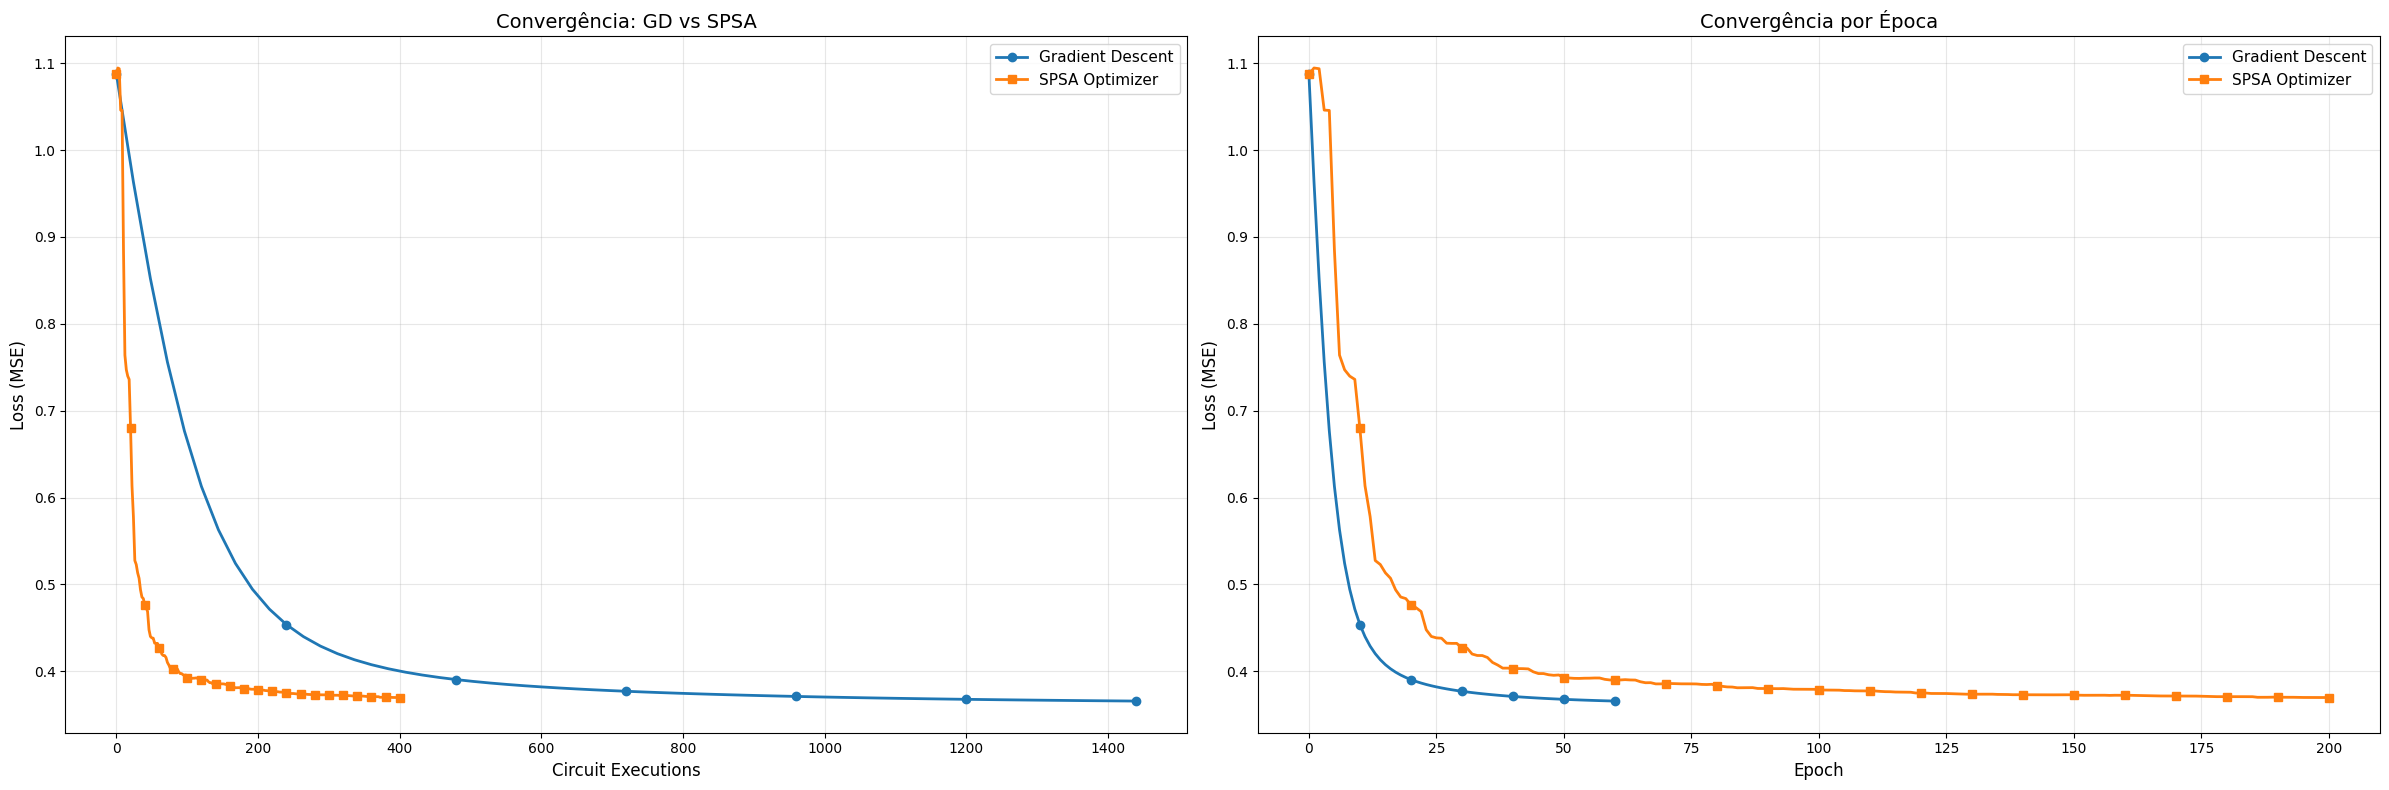

Gradient Descent          0.365692        1440                 66.37          
SPSA Optimizer            0.369748        400                  65.99          

Observações:
   • SPSA usou 400 execuções vs 1440 do GD
   • Eficiência SPSA: 3.6x menos execuções
   • Tempo de treinamento GD: 197.48 s vs SPSA: 214.73 s
   • Eficiência Tempo SPSA: 1.1x o tempo do GD


In [23]:
# Gráfico comparativo: Gradient Descent vs SPSA
plt.figure(figsize=(24, 8))

# Plot 1: Loss vs Circuit Executions
plt.subplot(1, 2, 1)
plt.plot(exec_history_gd, loss_history_gd, linewidth=2, label='Gradient Descent', color='#1f77b4', marker='o', markevery=10)
plt.plot(exec_history_spsa, loss_history_spsa, linewidth=2, label='SPSA Optimizer', color='#ff7f0e', marker='s', markevery=10)
plt.xlabel('Circuit Executions', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Convergência: GD vs SPSA', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot 2: Loss vs Epochs (para ver convergência temporal)
plt.subplot(1, 2, 2)
plt.plot(loss_history_gd, linewidth=2, label='Gradient Descent', color='#1f77b4', marker='o', markevery=10)
plt.plot(loss_history_spsa, linewidth=2, label='SPSA Optimizer', color='#ff7f0e', marker='s', markevery=10)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Convergência por Época', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Tabela comparativa
# print("\n" + "="*70)
# print(f"{'Método':<25} {'Loss Final':<15} {'Execuções Totais':<20} {'Tempo (s)':<15}")
# print("="*70)

initial_loss = loss_history_gd[0]
improvement_gd = ((initial_loss - loss_history_gd[-1]) / abs(initial_loss)) * 100
improvement_spsa = ((initial_loss - loss_history_spsa[-1]) / abs(initial_loss)) * 100

print(f"{'Gradient Descent':<25} {loss_history_gd[-1]:<15.6f} {exec_history_gd[-1]:<20} {improvement_gd:<15.2f}")
print(f"{'SPSA Optimizer':<25} {loss_history_spsa[-1]:<15.6f} {exec_history_spsa[-1]:<20} {improvement_spsa:<15.2f}")
# print("="*70)

print(f"\nObservações:")
print(f"   • SPSA usou {exec_history_spsa[-1]} execuções vs {exec_history_gd[-1]} do GD")
print(f"   • Eficiência SPSA: {exec_history_gd[-1] / exec_history_spsa[-1]:.1f}x menos execuções")
print(f"   • Tempo de treinamento GD: {duration_gd:.2f} s vs SPSA: {duration_spsa:.2f} s")
print(f"   • Eficiência Tempo SPSA: {duration_spsa / duration_gd :.1f}x o tempo do GD")

### 3.8.2 Interpretação dos Resultados


**Trade-off: Precisão vs Eficiência**

| Aspecto | Gradient Descent + Parameter-Shift | SPSA Optimizer |
|---------|------------------------------|----------------|
| **Gradientes** | Exatos (diferenciação automática) | Aproximados (perturbações aleatórias) |
| **Execuções/step** | 2x por parâmetro | 2 (constante) |
| **Convergência** | Suave e determinística | Ruidosa mas eficiente |
| **Escalabilidade** | Piora com mais parâmetros (O(N)) | Constante independente de N (O(1)) |
| **Hardware real?** |  Sim | Sim |

**Quando usar cada um?**

- **Gradient Descent + Parameter-Shift**: Desenvolvimento em simulador, prototipagem rápida
- **SPSA Optimizer**: Hardware quântico real, circuitos com muitos parâmetros (>50)

## 3.9 Avaliar e Salvar Modelo Treinado

### 3.9.1 Avaliação Rápida

Avaliação simples para verificar se o modelo está aprendendo.

In [24]:
## Gradient Descent
train_predictions_gd = [predict(Q_CIRCUIT_GD, params_gd, x) for x in X_train]
train_accuracy_gd = np.mean([pred == true for pred, true in zip(train_predictions_gd, y_train_quantum)])

test_predictions_gd = [predict(Q_CIRCUIT_GD, params_gd, x) for x in X_test]
test_accuracy_gd = np.mean([pred == true for pred, true in zip(test_predictions_gd, y_test_quantum)])


### SPSA
train_predictions_spsa = [predict(Q_CIRCUIT_SPSA, params_spsa, x) for x in X_train]
train_accuracy_spsa = np.mean([pred == true for pred, true in zip(train_predictions_spsa, y_train_quantum)])

test_predictions_spsa = [predict(Q_CIRCUIT_SPSA, params_spsa, x) for x in X_test]
test_accuracy_spsa = np.mean([pred == true for pred, true in zip(test_predictions_spsa, y_test_quantum)])

print("=== Resultados do Treinamento ===")
print(f"Dataset: {len(X_train)} treino, {len(X_test)} teste")

print(f"\nAcurácia Treino (GD): {train_accuracy_gd*100:.1f}%")
print(f"Acurácia Teste (GD): {test_accuracy_gd*100:.1f}%")
print(f"Loss Final (GD): {loss_history_gd[-1]:.4f}")

print(f"\nAcurácia Treino (SPSA): {train_accuracy_spsa*100:.1f}%")
print(f"Acurácia Teste (SPSA): {test_accuracy_spsa*100:.1f}%")
print(f"Loss Final (SPSA): {loss_history_spsa[-1]:.4f}")

=== Resultados do Treinamento ===
Dataset: 80 treino, 20 teste

Acurácia Treino (GD): 90.0%
Acurácia Teste (GD): 85.0%
Loss Final (GD): 0.3657

Acurácia Treino (SPSA): 88.8%
Acurácia Teste (SPSA): 85.0%
Loss Final (SPSA): 0.3697


### 3.9.2 Salvar Modelo Treinado

In [ ]:
np.save('../results/trained_params.npy', params_gd)
np.save('../results/loss_history_gd.npy', loss_history_gd)
np.save('../results/trained_params_spsa.npy', params_spsa)
np.save('../results/loss_history_spsa.npy', loss_history_spsa)

print(f"Parâmetros salvos em:")
print("../results/trained_params_gd.npy")
print("../results/trained_params_spsa.npy")
print(f"Histórico de loss salvo em:")
print("../results/loss_history_gd.npy")
print("../results/loss_history_spsa.npy")

Parâmetros salvos em:
../results/trained_params_gd.npy
../results/trained_params_spsa.npy
Histórico de loss salvo em:
../results/loss_history_gd.npy
../results/loss_history_spsa.npy


In [ ]:
np.save('../results/exec_history_gd.npy', exec_history_gd)
np.save('../results/exec_history_spsa.npy', exec_history_spsa)

print("Historico de Execuções salvos em:")
print("../results/exec_history_gd.npy")
print("../results/exec_history_spsa.npy")